# HW 3: Instance-Based Learning
## k-Nearest Neighbor 

We'll first setup the environment

In [1]:
# For the matrix math
import numpy as np
# For data manipulation
import pandas as pd
# For rendering the plots
import matplotlib.pyplot as plt
import pylab as pl
# For shuffling, folding and splitting the train and test data
from sklearn import cross_validation
from sklearn import preprocessing
# For calculating performance metrics
from sklearn.metrics import confusion_matrix, accuracy_score, zero_one_loss
# For classifying verification metrics
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings("ignore")
%config InlineBackend.figure_format='svg'
%matplotlib inline

Then load in the data

In [2]:
spam_DF = pd.read_csv('data/spambase.data',header=None)
# spam_DF
# spam_DF.describe()

In [3]:
alcohol_DF = pd.read_csv('data/alcoholism.csv', delim_whitespace=True)
# alcohol_DF
# alcohol_DF.describe()

In [4]:
musicgenre_DF = pd.read_csv('data/genre_classification.txt', delim_whitespace=True)
# musicgenre_DF
# musicgenre_DF.describe()

In [5]:
wine_DF = pd.read_csv('data/wine.data')
# wine_DF
# wine_DF.describe()
# wine_DF.tail()

In [6]:
office_DF = pd.read_csv('data/Office/train.csv',header=None)
office_DF = office_DF[list(range(0,71)) + [74]]
# wine_DF
# office_DF.describe()
# wine_DF.tail()

In [7]:
spam_X = np.matrix(spam_DF[list(range(0,57))])
spam_y = np.array(spam_DF[57])
spam = {'Lable': 'Spam', 'X': spam_X, 'y': spam_y}

alcohol_X = np.matrix(alcohol_DF[['f1','f2','f3','f4','f5','f6']])
alcohol_y = np.array(alcohol_DF['c'])
alcohol = {'Lable': 'Alcoholism', 'X': alcohol_X, 'y': alcohol_y}

musicgenre_X = np.matrix(musicgenre_DF[['f1','f2','f3','f4','f5','f6','f7','f8','f9','f10']])
musicgenre_y = np.array(musicgenre_DF['c'])
musicgenre = {'Lable': 'Music Genre', 'X': musicgenre_X, 'y': musicgenre_y}

wine_X = np.matrix(wine_DF[['f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11','f12','f13']])
wine_y = np.array(wine_DF['c'])
wine = {'Lable': 'Alcoholism', 'X': wine_X, 'y': wine_y}

office_X = np.matrix(office_DF[list(range(0,71))])
office_y = np.array(office_DF[74])
office = {'Lable': 'Spam', 'X': office_X, 'y': office_y}

dataSets = [spam, alcohol, musicgenre, wine, office]

Let’s make a little helper function to call our classifier for training and testing. Each dataset is trained using $TD$, or a random $80\%$ selection of the total data. This is because $TtD$, the rest of the $20\%$, will be withheld for final testing only. Randomly selected a subsets of $d\%$ from the TD, where $d = \left\{50\right\}$ are generated 5 times to make for training set $TS$. A $d\%$ of $100\%$ for $TD$ is also done.

For our procedure, we'll test TtD using each of the TS trained and use the lowest BIC to chose for the best K. This will be done and compared with each percentage of TS used. For the effective number of parameters, I've chosen to model this by:
$$BIC = 2 \cdot misclass \cdot N + \frac{N}{k} \cdot \log(N)$$

Where $N$ is the total number of data points in the training set and $K$ is the effective number of parameters of the model and can be thought of as a function of the degrees of freedom. When used for the purpose of model selection we choose the model that minimizes BIC.

In [8]:
def testClassification2(classifier, dataSet, D):
    X = dataSet['X']
    y = dataSet['y']
    
    #Let split the data making TtD and T
    X_TD, X_TtD, y_TD, y_TtD = cross_validation.train_test_split(X, y, test_size=0.20, random_state=42)
    
    n_iter = 100
    
    TS_results = {}
    # For each percentage
    for d in D:
        results = []
        for i in range(n_iter):
            X_train, X_test, y_train, y_test = cross_validation.train_test_split(X_TD, y_TD, test_size=1-d, random_state=int(42*d*i))
            try:
                classifier.fit(X_train,y_train)
                y_pred = classifier.predict(X_test)
                N = y_train.size
                misclass = (1-accuracy_score(y_test, y_pred))*N
                bic = 2.0*(misclass)*N + (N/classifier.n_neighbors)*np.log(N)
            except:
                bic = np.nan
            results.append(bic)
        mean = np.mean(results)
        std  = np.std(results)
        TS_results[d] = {'mean':mean, 'std':std}#, 'results': results}
    return TS_results

In [9]:
def testClassification3(classifier, dataSet, D):
    X = dataSet['X']
    y = dataSet['y']
    
    #Let split the data making TtD and T
    X_TD, X_TtD, y_TD, y_TtD = cross_validation.train_test_split(X, y, test_size=0.20, random_state=42)
    
    n_iter = 100
    
    TS_results = {}
    # For each percentage
    for d in D:
        results = []
        for i in range(n_iter):
            X_train, _, y_train, _ = cross_validation.train_test_split(X_TD, y_TD, test_size=1-d, random_state=int(42*d*i))
            X_test = X_TtD
            y_test= y_TtD
            try:
                classifier.fit(X_train,y_train)
                y_pred = classifier.predict(X_test)
                N = y_train.size
                misclass = (1-accuracy_score(y_test, y_pred))*N
                bic = 2.0*(misclass)*N + (N/classifier.n_neighbors)*np.log(N)
            except:
                bic = np.nan
            results.append(bic)
        mean = np.mean(results)
        std  = np.std(results)
        TS_results[d] = {'mean':mean, 'std':std}#, 'results': results}
    return TS_results

In [10]:
def setBoxColors(bp):
    plt.setp(bp['boxes'][0], color='blue')
    plt.setp(bp['caps'][0], color='blue')
    plt.setp(bp['caps'][1], color='blue')
    plt.setp(bp['whiskers'][0], color='blue')
    plt.setp(bp['whiskers'][1], color='blue')
#     plt.setp(bp['fliers'][0], color='blue')
#     plt.setp(bp['fliers'][1], color='blue')
    plt.setp(bp['medians'][0], color='blue')
    
    plt.setp(bp['boxes'][1], color='green')
    plt.setp(bp['caps'][2], color='green')
    plt.setp(bp['caps'][3], color='green')
    plt.setp(bp['whiskers'][2], color='green')
    plt.setp(bp['whiskers'][3], color='green')
    plt.setp(bp['fliers'][2], color='green')
#     plt.setp(bp['fliers'][3], color='green')
    plt.setp(bp['medians'][1], color='green')

    plt.setp(bp['boxes'][2], color='red')
    plt.setp(bp['caps'][4], color='red')
    plt.setp(bp['caps'][5], color='red')
    plt.setp(bp['whiskers'][4], color='red')
    plt.setp(bp['whiskers'][5], color='red')
#     plt.setp(bp['fliers'][4], color='red')
#     plt.setp(bp['fliers'][5], color='red')
    plt.setp(bp['medians'][2], color='red')
    
def plotResults(TS_results, title):
    fig = plt.figure(figsize=[8,4])
    ax = fig.add_subplot(111)
    plt.hold(True)
    
    TS = iter(sorted(TS_results.items()))
    for d, dresults in TS:
        N = iter(sorted(dresults['fold_results'].items()))
        loo_results = np.mean(dresults['loo_results']['loo_results'], axis=1)
        fold_results_2 = dresults['fold_results'][2]['kf_results']
        fold_results_5 = dresults['fold_results'][5]['kf_results']
        
        d_results = [fold_results_5,fold_results_2,loo_results]
        bp = plt.boxplot(d_results, positions = [d-0.06, d, d+0.06], widths = 0.04)
        setBoxColors(bp)
    
    ax.set_xticklabels(['20%', '50%', '80%', '100%'])
    ax.set_xticks([.2, .5, .8, 1])
    plt.xlim(.05,1.15)
    plt.ylim(0.0,1.0)
    plt.xlabel('TD Percentage')
    plt.ylabel('Accuracy')
    plt.title(title)
    
    hB, = plt.plot([1,1],'b-')
    hG, = plt.plot([1,1],'g-')
    hR, = plt.plot([1,1],'r-')
    plt.legend((hB, hG, hR),('5 Fold','2 Fold','LOO'),loc=4)
    hB.set_visible(False)
    hG.set_visible(False)
    hR.set_visible(False)
    
    plt.grid(axis='y')
    return fig

In [11]:
def testClassification(classifier, dataSet):
    X = dataSet['X']
    y = dataSet['y']
    
    #Let split the data making TtD and T
    X_TD, X_TtD, y_TD, y_TtD = cross_validation.train_test_split(X, y, test_size=0.20, random_state=42)
    
    D = [0.20,0.50,0.80,1]
    n_iter = 20
    n_folds = [2, 5]
    
    TS_results = {}
    # For each percentage [0.20,0.50,0.80,1.0]
    for d in D:
        fold_results = {}
        # For each fold [2,5]
        for n in n_folds:
            # For each set [1:5]
            kf_results = []
            for i in range(n_iter):
                X, _, y, _ = cross_validation.train_test_split(X_TD, y_TD, test_size=1-d, random_state=int(42*d*10+i))
                kf = cross_validation.KFold(n=len(X), n_folds=n)
                for train_index, test_index in kf:
                    X_test = X[test_index]
                    y_test= y[test_index]
                    X_train = X[train_index]
                    y_train = y[train_index]
                    classifier.fit(X_train,y_train)
                    y_pred = classifier.predict(X_TtD)
                    kf_results.append(accuracy_score(y_TtD, y_pred))
            mean = np.mean(kf_results)
            std  = np.std(kf_results)
            fold_results[n] = {'mean':mean, 'std':std, 'kf_results': kf_results}
        
        # For each set [1:5]
        loo_results = []
        for i in range(5):
            results = []
            X, _, y, _ = cross_validation.train_test_split(X_TD, y_TD, test_size=1-d, random_state=int(42*d*10+i))
            loo = cross_validation.LeaveOneOut(n=len(X))
            for train_index, test_index in loo:
                X_test = X[test_index]
                y_test= y[test_index]
                X_train = X[train_index]
                y_train = y[train_index]
                
                classifier.fit(X_train,y_train)
                y_pred = classifier.predict(X_TtD)
                results.append(accuracy_score(y_TtD, y_pred))
            loo_results.append(results)
        
        mean = np.mean(loo_results)
        std  = np.std(loo_results)
        loo_results = {'mean':mean, 'std':std, 'loo_results': loo_results}
        TS_results[d] = {'fold_results': fold_results, 'loo_results': loo_results}
    return TS_results

### Dataset: Alcohol

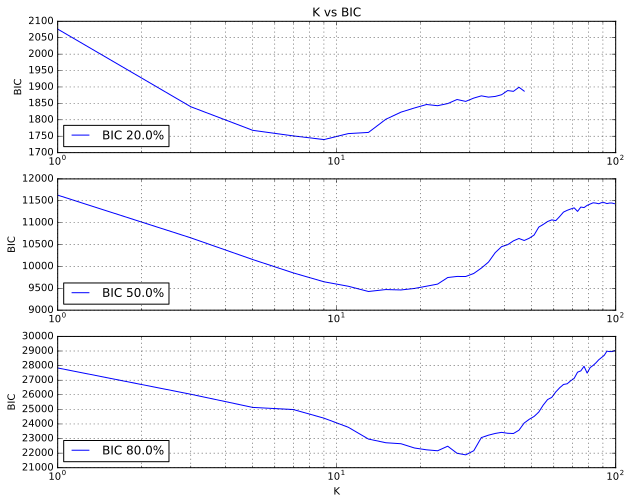

In [12]:
dataSet = alcohol

Ks = range(1, 100, 2)
Ds = [0.20, 0.50, 0.8]#, 1]
bic = {}
for d in Ds:
    bic[d] = []

for k in Ks:
    knnc = KNeighborsClassifier(n_neighbors=k, metric='chebyshev')
    TtD_results = testClassification2(knnc, dataSet, Ds)
    for d in Ds:
        bic[d].append(TtD_results[d]['mean'])
        

fig, axs = plt.subplots(nrows=len(Ds),figsize=[10,8])
axs[0].set_title('K vs BIC')
for d, ax in zip(Ds,axs):
    label = 'BIC ' + str(d*100) + '%'
    ax.plot(Ks,bic[d],  label=label)
    # ax.set_yscale('log')
    ax.set_xscale('log')
    ax.grid(which='both')
    ax.legend(loc=3)
    ax.set_ylabel('BIC')

plt.xlabel('K')
plt.show()

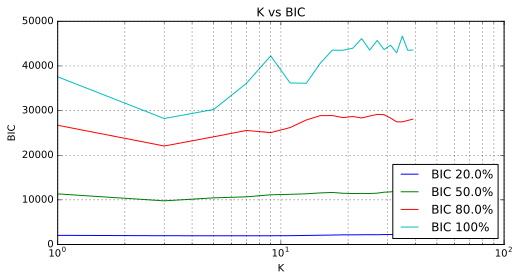

In [13]:
dataSet = alcohol

Ks = range(1, 40, 2)
Ds = [0.2, 0.50, 0.8, 1]
bic = {}
for d in Ds:
    bic[d] = []

for k in Ks:
    knnc = KNeighborsClassifier(n_neighbors=k, metric='chebyshev')
    TtD_results = testClassification3(knnc, dataSet, Ds)
    for d in Ds:
        bic[d].append(TtD_results[d]['mean'])
        
fig, ax = plt.subplots(figsize=[8,4])
for d in Ds:
    label = 'BIC ' + str(d*100) + '%'
    ax.plot(Ks,bic[d],  label=label)
    
ax.set_title('K vs BIC')
ax.set_xlabel('K')
ax.set_ylabel('BIC')
# ax.set_yscale('log')
ax.set_xscale('log')
ax.grid(which='both')
ax.legend(loc=4)
plt.show()

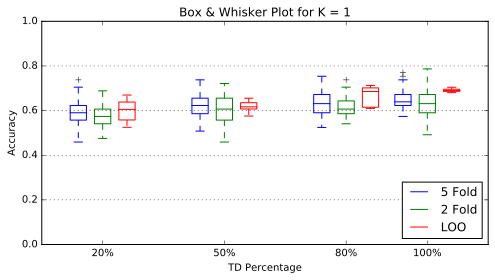

Validation Accuracy for K = 1
0.691558397388


In [14]:
K = 1
knnc = KNeighborsClassifier(n_neighbors=K,metric='chebyshev')
TtD_results = testClassification(knnc, dataSet)
TtD_results
title = 'Box & Whisker Plot for K = ' + str(K)
fig = plotResults(TtD_results, title)
plt.show()

print('Validation Accuracy for K = ' + str(K))
print(TtD_results[1.0]['loo_results']['mean'])

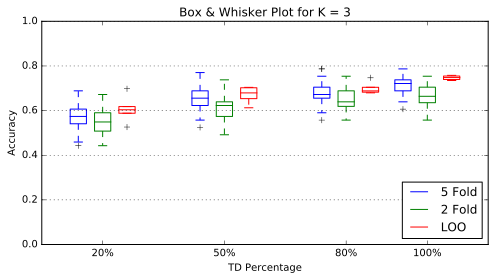

Validation Accuracy for K = 3
0.746983198422


In [15]:
K = 3
knnc = KNeighborsClassifier(n_neighbors=K,metric='chebyshev')
TtD_results = testClassification(knnc, dataSet)
TtD_results
title = 'Box & Whisker Plot for K = ' + str(K)
fig = plotResults(TtD_results, title)
plt.show()

print('Validation Accuracy for K = ' + str(K))
print(TtD_results[1.0]['loo_results']['mean'])

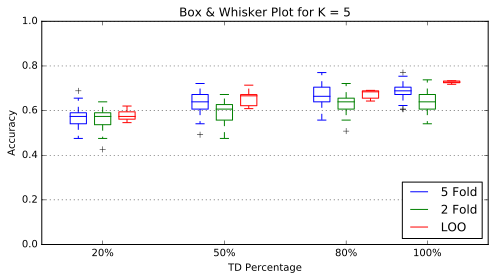

Validation Accuracy for K = 5
0.727283858241


In [16]:
K = 5
knnc = KNeighborsClassifier(n_neighbors=K,metric='chebyshev')
TtD_results = testClassification(knnc, dataSet)
TtD_results
title = 'Box & Whisker Plot for K = ' + str(K)
fig = plotResults(TtD_results, title)
plt.show()

print('Validation Accuracy for K = ' + str(K))
print(TtD_results[1.0]['loo_results']['mean'])

### Dataset: Wine

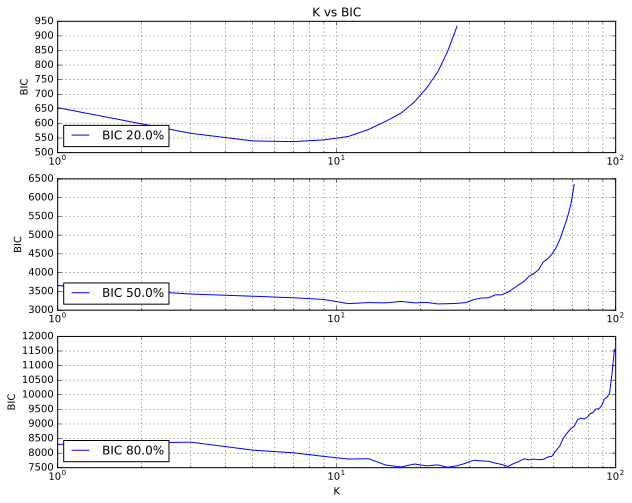

In [17]:
dataSet = wine

Ks = range(1, 100, 2)
Ds = [0.20, 0.50, 0.8]#, 1]
bic = {}
for d in Ds:
    bic[d] = []

for k in Ks:
    knnc = KNeighborsClassifier(n_neighbors=k, metric='chebyshev')
    TtD_results = testClassification2(knnc, dataSet, Ds)
    for d in Ds:
        bic[d].append(TtD_results[d]['mean'])
        

fig, axs = plt.subplots(nrows=len(Ds),figsize=[10,8])
axs[0].set_title('K vs BIC')
for d, ax in zip(Ds,axs):
    label = 'BIC ' + str(d*100) + '%'
    ax.plot(Ks,bic[d],  label=label)
    # ax.set_yscale('log')
    ax.set_xscale('log')
    ax.grid(which='both')
    ax.legend(loc=3)
    ax.set_ylabel('BIC')

plt.xlabel('K')
plt.show()

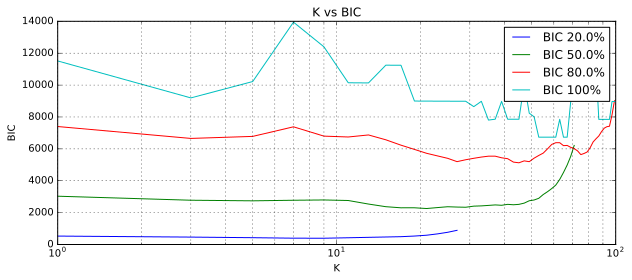

In [18]:
dataSet = wine

Ks = range(1, 100, 2)
Ds = [0.2, 0.50, 0.8, 1]
bic = {}
for d in Ds:
    bic[d] = []

for k in Ks:
    knnc = KNeighborsClassifier(n_neighbors=k, metric='chebyshev')
    TtD_results = testClassification3(knnc, dataSet, Ds)
    for d in Ds:
        bic[d].append(TtD_results[d]['mean'])
        
fig, ax = plt.subplots(figsize=[10,4])
for d in Ds:
    label = 'BIC ' + str(d*100) + '%'
    ax.plot(Ks,bic[d],  label=label)
    
ax.set_title('K vs BIC')
ax.set_xlabel('K')
ax.set_ylabel('BIC')
# ax.set_yscale('log')
ax.set_xscale('log')
ax.grid(which='both')
ax.legend(loc=1)
plt.show()

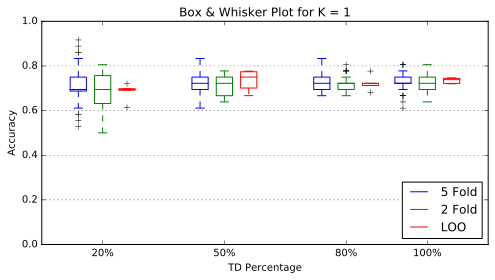

Validation Accuracy for K = 1
0.734350547731


In [19]:
K = 1
knnc = KNeighborsClassifier(n_neighbors=K,metric='chebyshev')
TtD_results = testClassification(knnc, dataSet)
TtD_results
title = 'Box & Whisker Plot for K = ' + str(K)
fig = plotResults(TtD_results, title)
plt.show()

print('Validation Accuracy for K = ' + str(K))
print(TtD_results[1.0]['loo_results']['mean'])

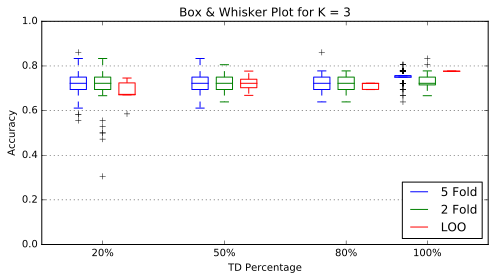

Validation Accuracy for K = 3
0.776447574335


In [20]:
K = 3
knnc = KNeighborsClassifier(n_neighbors=K,metric='chebyshev')
TtD_results = testClassification(knnc, dataSet)
TtD_results
title = 'Box & Whisker Plot for K = ' + str(K)
fig = plotResults(TtD_results, title)
plt.show()

print('Validation Accuracy for K = ' + str(K))
print(TtD_results[1.0]['loo_results']['mean'])

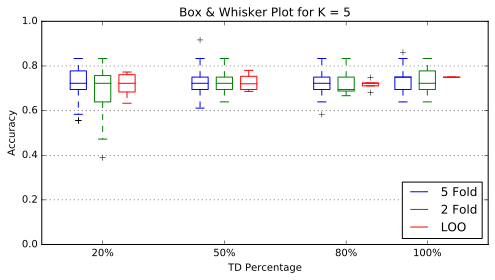

Validation Accuracy for K = 5
0.749726134585


In [21]:
K = 5
knnc = KNeighborsClassifier(n_neighbors=K,metric='chebyshev')
TtD_results = testClassification(knnc, dataSet)
TtD_results
title = 'Box & Whisker Plot for K = ' + str(K)
fig = plotResults(TtD_results, title)
plt.show()

print('Validation Accuracy for K = ' + str(K))
print(TtD_results[1.0]['loo_results']['mean'])